Consider a current $I$ flowing counterclockwise in a loop in the xy-plane with a 3-petal shape as follows:

$$\vec{l}(t) = R\left[1+\frac{3}{4}\sin(3 t)\right] \cdot \left<\cos t, \sin t, 0 \right> $$

where $0 \leq t \leq 2\pi$. The Biot-Savard Law tells us

$$\vec{B}(\vec{r}) =  \frac{\mu_0 I}{4 \pi} \int_C \frac{d\vec{l} \times (\vec{r}-\vec{l})}{|\vec{r}-\vec{l}|^3} = \int_0^{2 \pi} \frac{d\vec{l}/dt \times (\vec{r} - \vec{l})}{|\vec{r}-\vec{l}|^3} dt$$

Putting this in dimensionless form

* $\vec{l} \to \vec{l}/R$
* $\vec{r} \to \vec{r}/R$

we get

$$\frac{4 \pi R}{\mu_0 I} \vec{B}(\vec{r}) = \int_0^{2 \pi} \frac{d\vec{l}/dt \times (\vec{r} - \vec{l})}{|\vec{r}-\vec{l}|^3} dt$$


In [182]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, quad_vec
import plotly.graph_objects as go
from IPython.display import HTML
import sympy as smp
from sympy.vector import cross
from IPython.display import Image, display
from IPython.core.display import HTML

Start by looking at curve

In [184]:
phi = np.linspace(0, 2*np.pi, 100)

def l(phi):
    return (1+3/4 * np.sin(3*phi)) * np.array([np.cos(phi), np.sin(phi), np.zeros(len(phi))])

'''
def l(phi):
    return np.array([np.cos(phi), np.sin(phi), (phi-np.pi)/np.pi])
    '''

'\ndef l(phi):\n    return np.array([np.cos(phi), np.sin(phi), (phi-np.pi)/np.pi])\n    '

In [185]:
lx, ly, lz = l(phi)

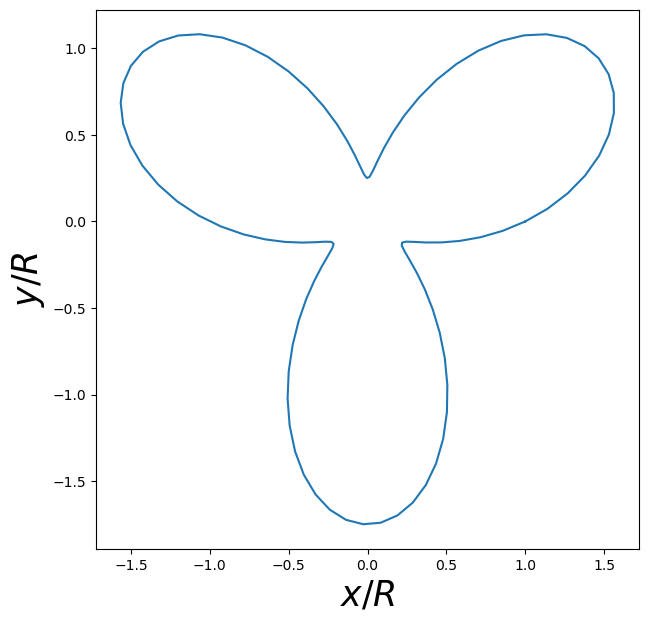

In [186]:
plt.figure(figsize=(7,7))
plt.plot(lx, ly)
plt.xlabel('$x/R$', fontsize=25)
plt.ylabel('$y/R$', fontsize=25)
plt.show()

Lets solve for the integrand using sympy

In [188]:
t, x, y, z = smp.symbols('t, x, y, z')

Get $l$, $r$, and the seperation vector $\vec{r} - \vec{l}$

In [190]:
l = (1+(3/4)*smp.sin(3*t))*smp.Matrix([smp.cos(t), smp.sin(t), 0])
#l = smp.Matrix([smp.cos(t), smp.sin(t), (t-smp.pi)/smp.pi])
r = smp.Matrix([x, y, z])
sep = r-l

Define the integrand

In [192]:
integrand = smp.diff(l, t).cross(sep) / sep.norm()**3

In [193]:
integrand

Matrix([
[                                                                                                                          z*((0.75*sin(3*t) + 1)*cos(t) + 2.25*sin(t)*cos(3*t))/(Abs(z)**2 + Abs(x - (0.75*sin(3*t) + 1)*cos(t))**2 + Abs(y - (0.75*sin(3*t) + 1)*sin(t))**2)**(3/2)],
[                                                                                                                        -z*(-(0.75*sin(3*t) + 1)*sin(t) + 2.25*cos(t)*cos(3*t))/(Abs(z)**2 + Abs(x - (0.75*sin(3*t) + 1)*cos(t))**2 + Abs(y - (0.75*sin(3*t) + 1)*sin(t))**2)**(3/2)],
[(-(x - (0.75*sin(3*t) + 1)*cos(t))*((0.75*sin(3*t) + 1)*cos(t) + 2.25*sin(t)*cos(3*t)) + (y - (0.75*sin(3*t) + 1)*sin(t))*(-(0.75*sin(3*t) + 1)*sin(t) + 2.25*cos(t)*cos(3*t)))/(Abs(z)**2 + Abs(x - (0.75*sin(3*t) + 1)*cos(t))**2 + Abs(y - (0.75*sin(3*t) + 1)*sin(t))**2)**(3/2)]])

Get the $x$, $y$, and $z$ components of the integrand

In [195]:
dBxdt = smp.lambdify([t, x, y, z], integrand[0])
dBydt = smp.lambdify([t, x, y, z], integrand[1])
dBzdt = smp.lambdify([t, x, y, z], integrand[2])

In [196]:
quad(dBxdt, 0, 2*np.pi, args = (1, 1, 1))[0]

0.36721505285419803

Get the magnetic field by performing the integral over each component

In [198]:
def B(x, y, z):
    return np.array([quad_vec(dBxdt, 0, 2*np.pi, args=(x, y, z))[0],
                     quad_vec(dBydt, 0, 2*np.pi, args=(x, y, z))[0],
                     quad_vec(dBzdt, 0, 2*np.pi, args=(x, y, z))[0]])

In [199]:
B(0.5, 0.5, 1)

array([0.19069963, 0.52786431, 1.52524645])

Set up a meshgrid to solve for the field in some 3D volume

In [201]:
x = np.linspace(-2, 2, 20)
xv, yv, zv = np.meshgrid(x, x, x)

In [202]:
#B_field = B(xv, yv, zv)
#Bx, By, Bz = B_field

In [ ]:
B_field = np.vectorize(B, signature= '(),(),()->(n)')(xv, yv, zv)
Bx = B_field[:,:,:,0]
By = B_field[:,:,:,1]
Bz = B_field[:,:,:,2]

In [ ]:
Bx[Bx>20] = 20
By[By>20] = 20
Bz[Bz>20] = 20

Bx[Bx<-20] = -20
By[By<-20] = -20
Bz[Bz<-20] = -20

Use plotly to make an interactive 3D plot

In [ ]:
xv.ravel()

In [ ]:
data = go.Cone(x=xv.ravel(), y=yv.ravel(), z=zv.ravel(),
               u=Bx.ravel(), v=By.ravel(), w=Bz.ravel(),
               colorscale='Inferno', colorbar=dict(title='$x^2$'),
               sizemode="absolute", sizeref=20)

layout = go.Layout(title=r'Plot Title',
                     scene=dict(xaxis_title=r'x',
                                yaxis_title=r'y',
                                zaxis_title=r'z',
                                aspectratio=dict(x=1, y=1, z=1),
                                camera_eye=dict(x=1.2, y=1.2, z=1.2))) 

fig = go.Figure(data = data, layout=layout)
fig.add_scatter3d(x=lx, y=ly, z=lz, mode='lines',
                   line = dict(color='black', width=5))

HTML(fig.to_html())
fig.write_html('first_figure.html', auto_open=True)